
# Модуль 4 — Семинарский ноутбук (v2)  
**Анализ и синтез изображений — практика с формулами и PyTorch**


## 1. Окружение и воспроизводимость


In [2]:

import sys, platform, numpy as np, torch, sklearn, matplotlib
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

print("Python:", sys.version.split()[0])
print("OS:", platform.system(), platform.release())
print("NumPy:", np.__version__)
print("PyTorch:", torch.__version__, "| CUDA:", torch.cuda.is_available())
print("sklearn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)


Python: 3.11.14
OS: Linux 6.6.87.2-microsoft-standard-WSL2
NumPy: 2.3.4
PyTorch: 2.9.0+cu128 | CUDA: True
sklearn: 1.7.2
matplotlib: 3.10.7



## 2. HOG + SVM (классика): распознавание рукописных цифр

**Идея HOG.** Считаем гистограммы ориентированных градиентов в ячейках и нормируем в блоках — получаем вектор признаков формы.

**Формулы.** Для пикселя $(x,y)$:
$$
g_x = I(x+1,y) - I(x-1,y),\quad
g_y = I(x,y+1) - I(x,y-1)
$$
$$
m=\sqrt{g_x^2 + g_y^2},\quad
\theta=\mathrm{atan2}(g_y,g_x)
$$

L2-нормализация гистограммы $h$ в блоке:
$$
\hat{h} = \frac{h}{\sqrt{\lVert h\rVert_2^2 + \varepsilon^2}}
$$


Accuracy: 0.8703703703703703
              precision    recall  f1-score   support

           0     0.9259    0.9259    0.9259        54
           1     0.9038    0.8545    0.8785        55
           2     0.9231    0.9057    0.9143        53
           3     0.8400    0.7636    0.8000        55
           4     0.8571    0.8889    0.8727        54
           5     0.7656    0.8909    0.8235        55
           6     0.9636    0.9815    0.9725        54
           7     0.8966    0.9630    0.9286        54
           8     0.8837    0.7308    0.8000        52
           9     0.7679    0.7963    0.7818        54

    accuracy                         0.8704       540
   macro avg     0.8727    0.8701    0.8698       540
weighted avg     0.8724    0.8704    0.8698       540



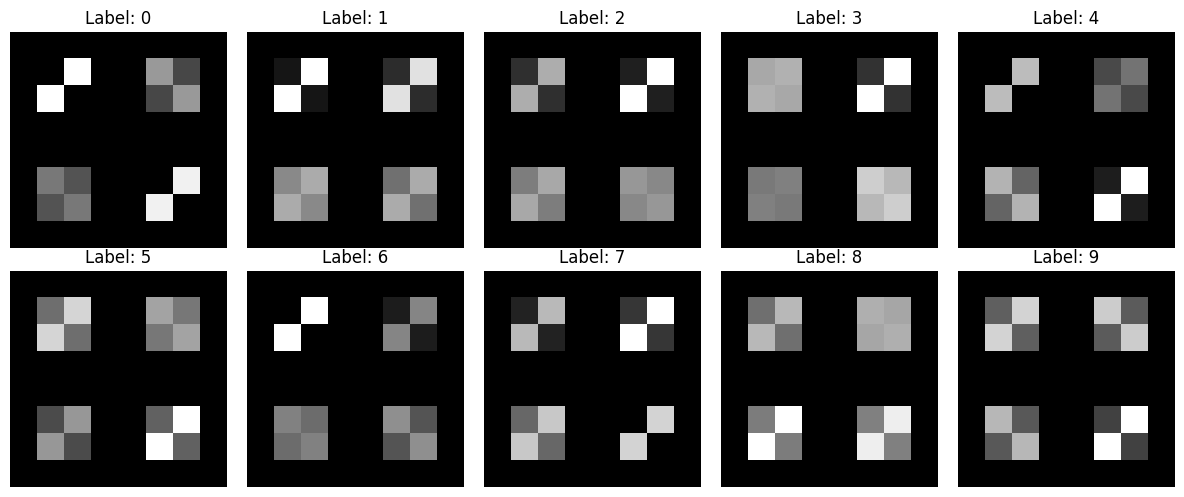

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

digits = datasets.load_digits()
images = digits.images
labels = digits.target

def extract_hog_features(images):
    feats = []
    for img in images:
        fd = hog(img, orientations=8, pixels_per_cell=(4,4),
                 cells_per_block=(2,2), block_norm="L2-Hys", visualize=False)
        feats.append(fd)
    return np.array(feats)

X = extract_hog_features(images)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, stratify=labels, random_state=42)

svm = SVC(kernel="linear", probability=True, random_state=42)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

# Визуализация HOG-карт
fig, axes = plt.subplots(2,5, figsize=(12,5))
for ax, img, lab in zip(axes.ravel(), images[:10], labels[:10]):
    fd, hog_img = hog(img, orientations=8, pixels_per_cell=(4,4),
                      cells_per_block=(2,2), block_norm="L2-Hys", visualize=True)
    ax.imshow(exposure.rescale_intensity(hog_img, in_range=(0, 10)), cmap="gray")
    ax.set_title(f"Label: {lab}")
    ax.axis("off")
plt.tight_layout(); plt.show()


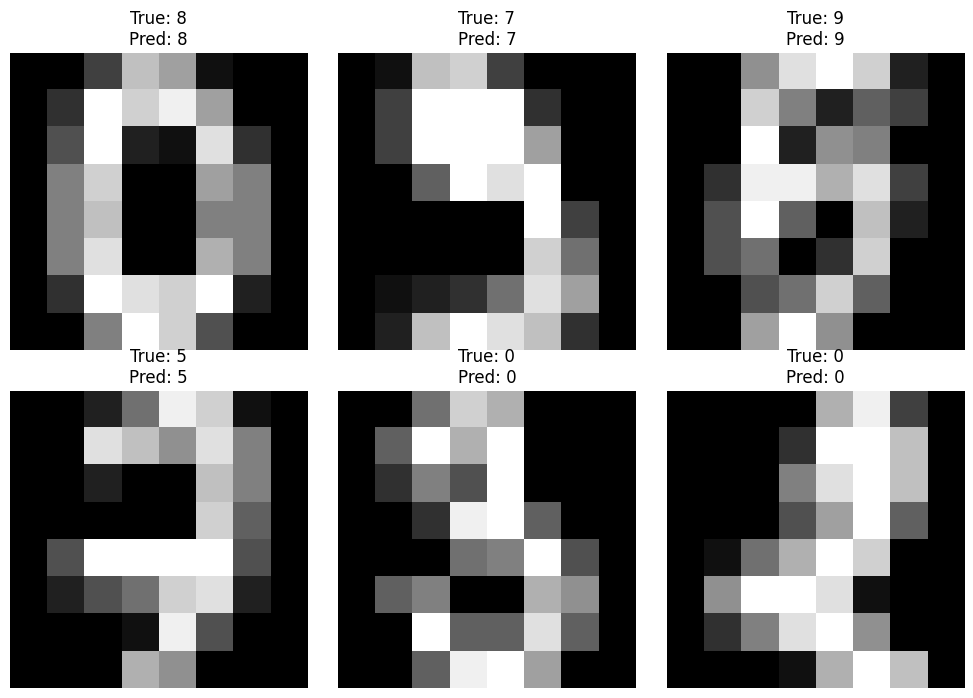

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Выбор 6 случайных изображений из тестовой выборки
random_indices = np.random.choice(len(X_test), 6, replace=False)
random_images = X_test[random_indices]
random_labels = y_test[random_indices]
predicted_labels = svm.predict(random_images)

# Отображение изображений с подписями распознанных классов
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
for ax, img, true_label, pred_label in zip(
    axes.ravel(), random_indices, random_labels, predicted_labels
):
    ax.imshow(digits.images[img], cmap=plt.cm.gray)
    ax.set_title(f"True: {true_label}\nPred: {pred_label}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# 3. Для демонстрации ограничений метода HOG+SVM 
можно использовать более сложный датасет, такой как CIFAR-10. CIFAR-10 содержит изображения различных объектов, что делает задачу распознавания более сложной. Мы будем использовать этот датасет, чтобы показать, как модель HOG+SVM справляется с более сложными изображениями, и затем визуализируем распознавание для 6 случайных изображений.

Вот как это сделать:

1. Загрузим и подготовим датасет CIFAR-10.
2. Извлечем HOG признаки.
3. Обучим модель SVM.
4. Сделаем предсказания и визуализируем их.


Классы CIFAR-10: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Размерность HOG признаков (обучающая выборка): (1000, 288)
Размерность HOG признаков (тестовая выборка): (1000, 288)
Accuracy: 0.415
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.42      0.45       100
           1       0.51      0.59      0.55       100
           2       0.38      0.34      0.36       100
           3       0.24      0.26      0.25       100
           4       0.34      0.36      0.35       100
           5       0.38      0.40      0.39       100
           6       0.40      0.48      0.44       100
           7       0.46      0.42      0.44       100
           8       0.43      0.40      0.41       100
           9       0.56      0.48      0.52       100

    accuracy                           0.41      1000
   macro avg       0.42      0.42      0.42      1000
weighted avg       0.42      0.4

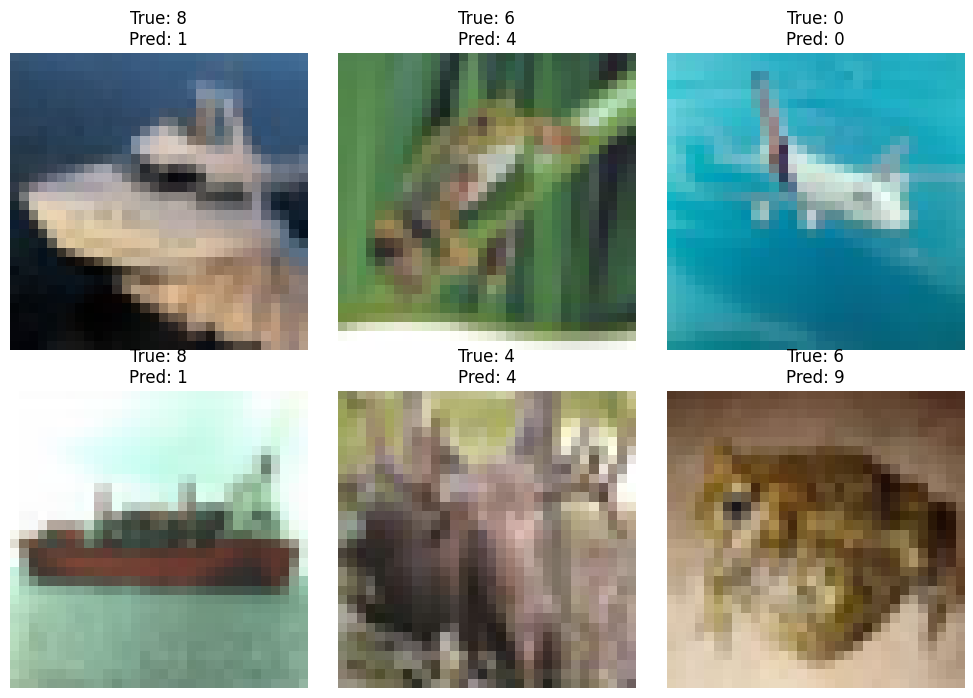

In [27]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import color
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from torchvision import datasets

# Папка для хранения/загрузки данных
DATA_DIR = "/mnt/d/datasets" # например путь к папке с данными на диске D

# Загружаем CIFAR‑10 без преобразований: получаем пары (PIL‑изображение, метка)
train_ds = datasets.CIFAR10(root=DATA_DIR, train=True,  download=True, transform=None)
test_ds  = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=None)

classes = train_ds.classes

print("Классы CIFAR-10:", classes)

# Преобразуем наборы в массивы изображений и меток
X_train = np.array([np.array(img) for img, _ in train_ds])
y_train = np.array([label for _, label in train_ds])

X_test  = np.array([np.array(img) for img, _ in test_ds])
y_test  = np.array([label for _, label in test_ds])

# Выберем подмножество данных для ускорения (например, 1000 изображений)
subset_size = 1000
X_train_subset, _, y_train_subset, _ = train_test_split(
    X_train, y_train, train_size=subset_size, stratify=y_train, random_state=42
)
X_test_subset, _, y_test_subset, _ = train_test_split(
    X_test, y_test, train_size=subset_size, stratify=y_test, random_state=42
)

# Функция извлечения HOG‑признаков
def extract_hog_features(images):
    hog_features = []
    for image in images:
        # переводим в grayscale
        gray_image = color.rgb2gray(image)
        # извлекаем HOG‑признаки
        fd = hog(
            gray_image,
            orientations=8,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm="L2-Hys",
            visualize=False,
        )
        hog_features.append(fd)
    return np.array(hog_features)

# Получаем HOG‑признаки для обучающей и тестовой выборок
X_train_hog = extract_hog_features(X_train_subset)
X_test_hog  = extract_hog_features(X_test_subset)

print("Размерность HOG признаков (обучающая выборка):", X_train_hog.shape)
print("Размерность HOG признаков (тестовая выборка):", X_test_hog.shape)

# Обучаем линейный SVM
svm = SVC(kernel="linear")
svm.fit(X_train_hog, y_train_subset)

# Предсказываем на тестовых данных
y_pred = svm.predict(X_test_hog)

# Оцениваем точность
print("Accuracy:", accuracy_score(y_test_subset, y_pred))
print("Classification Report:")
print(classification_report(y_test_subset, y_pred))

# Визуализация результатов для случайных 6 изображений
random_indices = np.random.choice(len(X_test_subset), 6, replace=False)
random_images = X_test_subset[random_indices]
random_labels = y_test_subset[random_indices]
predicted_labels = svm.predict(X_test_hog[random_indices])

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
for ax, img, true_label, pred_label in zip(
    axes.ravel(), random_images, random_labels, predicted_labels
):
    ax.imshow(img)
    ax.set_title(f"True: {true_label}\nPred: {pred_label}")
    ax.axis("off")

plt.tight_layout()
plt.show()



## 4. Сопоставление шаблонов (NCC)


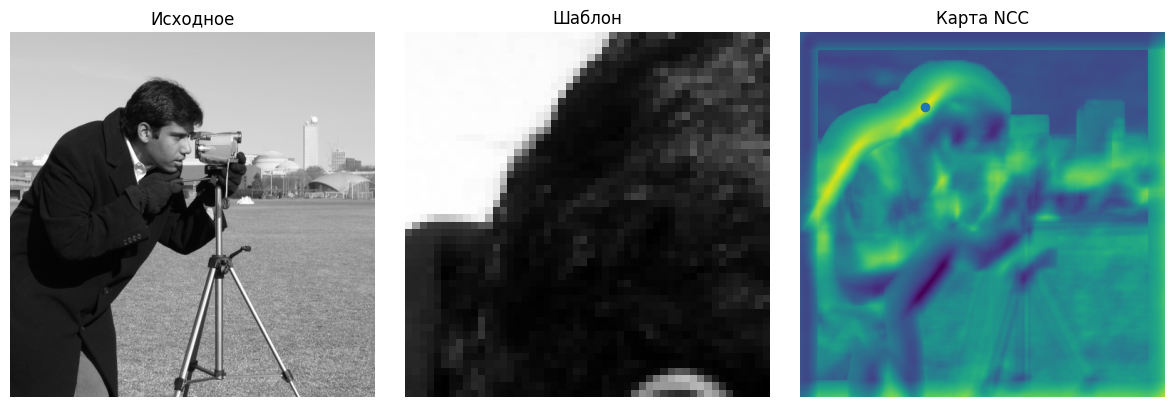

In [7]:

import numpy as np, matplotlib.pyplot as plt
from skimage.data import camera
from skimage.feature import match_template

img = camera()
template = img[80:130, 150:200]
result = match_template(img, template, pad_input=True)

ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))
ax1.imshow(img, cmap="gray"); ax1.set_title("Исходное"); ax1.axis("off")
ax2.imshow(template, cmap="gray"); ax2.set_title("Шаблон"); ax2.axis("off")
ax3.imshow(result); ax3.set_title("Карта NCC"); ax3.plot(x, y, "o"); ax3.axis("off")
plt.tight_layout(); plt.show()



## 5. Сегментация: Оцу + морфология + контуры


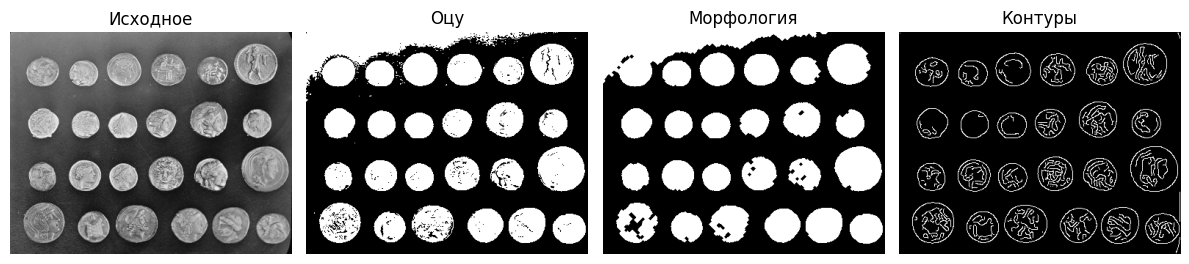

In [8]:

import numpy as np, matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.morphology import opening, closing, disk
from skimage.feature import canny
from skimage.data import coins

img = coins()
t = threshold_otsu(img)
mask = img > t
mask_clean = closing(opening(mask, disk(2)), disk(2))
edges = canny(img, sigma=1.5)

fig, axes = plt.subplots(1,4, figsize=(12,4))
titles = ["Исходное","Оцу","Морфология","Контуры"]
for ax, im, ttl in zip(axes, [img, mask, mask_clean, edges], titles):
    ax.imshow(im, cmap="gray"); ax.set_title(ttl); ax.axis("off")
plt.tight_layout(); plt.show()



## 6. PyTorch: простая CNN для цифр + saliency

Мы решаем две связанные задачи на наборе digits (8×8, 10 классов):

обучаем небольшую сверточную сеть (CNN) для классификации цифр;

строим карты заметности (saliency) — показываем, какие пиксели сильнее всего влияют на решение сети.

Функция потерь и оптимизация

Используем кросс-энтропию:

$$
\mathcal{L} = -\sum_{c} y_c \log p_c
$$

где 
- $y_c$ — one-hot целевая метка, 
- $p_c$ — softmax-вероятность класса 

В PyTorch мы подаём логиты в nn.CrossEntropyLoss, а softmax и one-hot делать не нужно: модуль сам применяет log_softmax и берёт индекс класса из y.

Оптимизатор Adam с lr=1e-3 — быстрый и устойчивый для такого масштаба.


### Saliency-карта

Интуитивно saliency показывает, как малая вариация каждого пикселя входа влияет на «уверенность» модели в выбранном классе \(c\).

Определение (градиент логита по входу):
$$
\mathrm{Saliency}(x)
\;=\;
\left\lVert \frac{\partial\, s_c(x)}{\partial\, x} \right\rVert
\;\;\;\;\text{или покомпонентно}\;\;\;\;
\mathrm{Saliency}_i(x)
=
\left|
\frac{\partial\, s_c(x)}{\partial\, x_i}
\right|,
$$
где \(x\in\mathbb{R}^{H\times W(\times 3)}\) — входное изображение (тензор пикселей),  
\(s_c(x)\) — логит (до softmax) для класса \(c\).

На практике часто берут модуль градиента:
$$
\mathrm{Saliency}(x) \;=\; \left| \frac{\partial\, s_c(x)}{\partial\, x} \right|
$$


Epoch 5: loss=2.3044, val_acc=0.1306


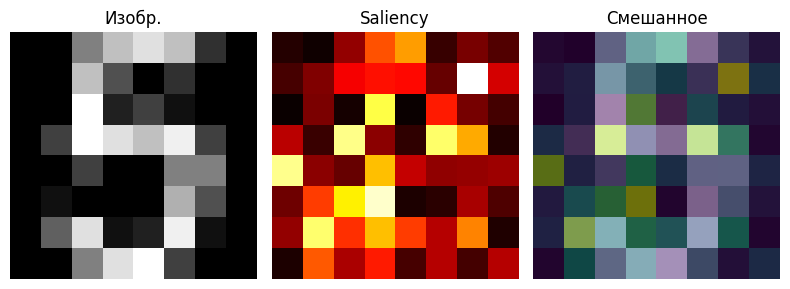

Epoch 10: loss=2.2998, val_acc=0.1333


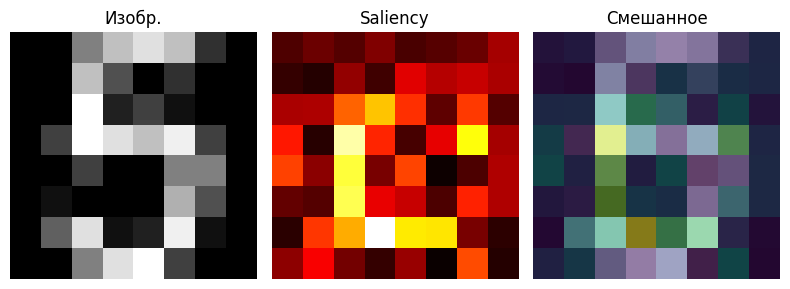

Epoch 15: loss=2.2958, val_acc=0.1417


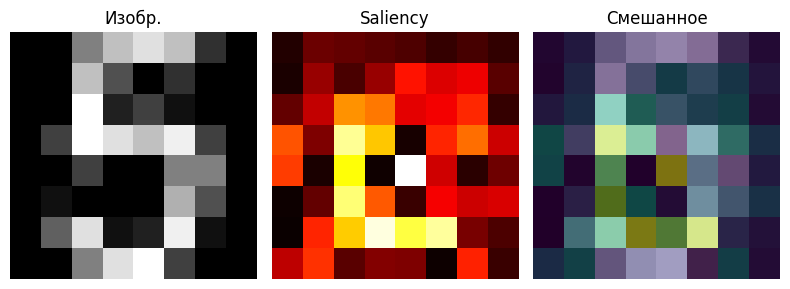

Epoch 20: loss=2.2915, val_acc=0.2528


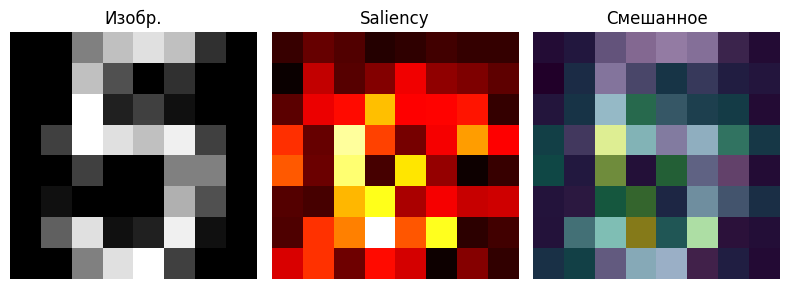

Epoch 25: loss=2.2861, val_acc=0.1917


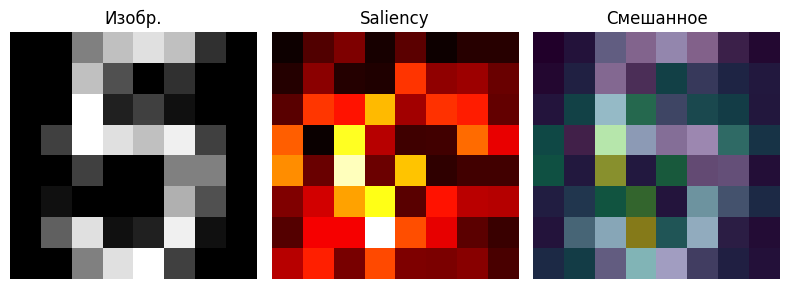

Epoch 30: loss=2.2796, val_acc=0.1778


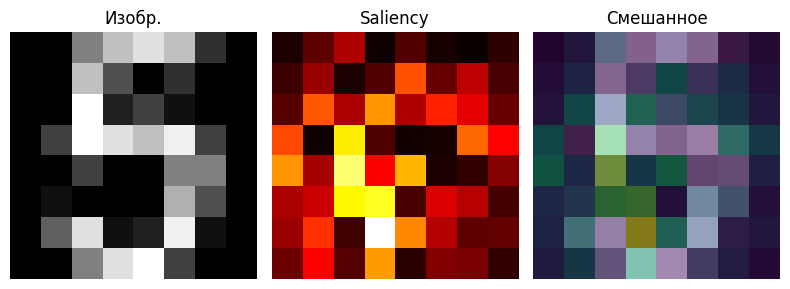

Epoch 35: loss=2.2712, val_acc=0.3056


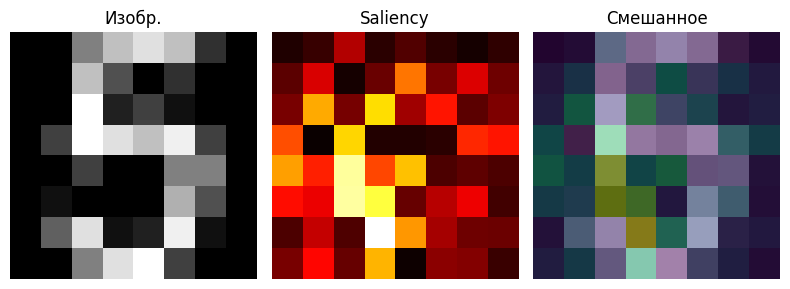

Epoch 40: loss=2.2603, val_acc=0.4333


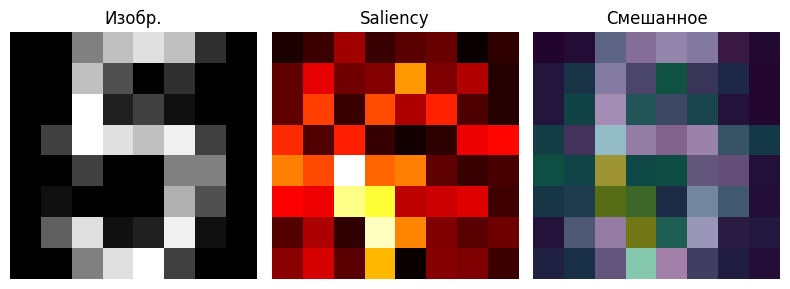

Epoch 45: loss=2.2464, val_acc=0.4694


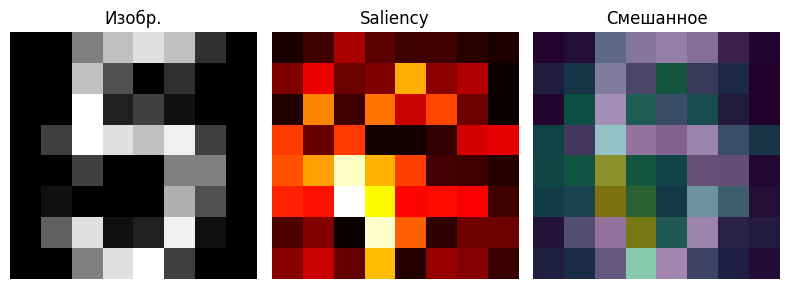

Epoch 50: loss=2.2291, val_acc=0.4750


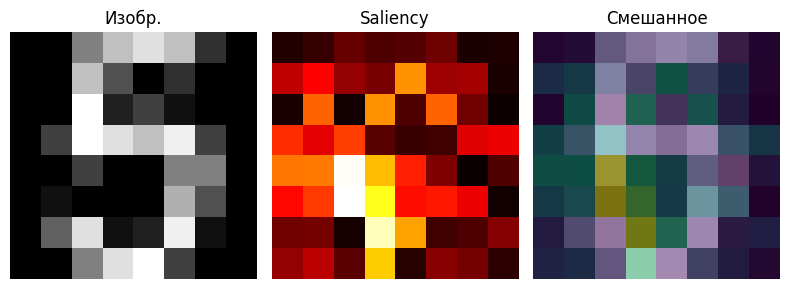

In [30]:

import torch, torch.nn as nn, torch.optim as optim
from sklearn.model_selection import train_test_split

# Используем digits (8x8) из блока HOG
X_img = images.astype("float32") / 16.0
y = torch.tensor(labels, dtype=torch.long)

X_train_img, X_val_img, y_train_t, y_val_t = train_test_split(X_img, y, test_size=0.2, stratify=y, random_state=42)
X_train_t = torch.tensor(X_train_img).unsqueeze(1)
X_val_t = torch.tensor(X_val_img).unsqueeze(1)

class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Linear(32, 10)
    def forward(self, x):
        x = self.net(x); x = x.view(x.size(0), -1); return self.fc(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

X_train_t, y_train_t = X_train_t.to(device), y_train_t.to(device)
X_val_t, y_val_t = X_val_t.to(device), y_val_t.to(device)

for epoch in range(50):
    model.train(); opt.zero_grad()
    loss = criterion(model(X_train_t), y_train_t)
    loss.backward(); opt.step()
    with torch.no_grad():
        model.eval()
        val_acc = (model(X_val_t).argmax(1) == y_val_t).float().mean().item()
    if (epoch+1)%5==0:
        print(f"Epoch {epoch+1}: loss={loss.item():.4f}, val_acc={val_acc:.4f}")

        # Saliency
        model.eval()
        x = X_val_t[0:1].clone().detach().requires_grad_(True)
        logits = model(x)
        cls = logits.argmax(1)
        loss_ex = criterion(logits, cls)
        model.zero_grad(); loss_ex.backward()
        sal = x.grad.abs().detach().cpu().squeeze().numpy()

        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(1,3, figsize=(8,3))
        ax[0].imshow(X_val_img[0], cmap="gray"); ax[0].set_title("Изобр."); ax[0].axis("off")
        ax[1].imshow(sal, cmap="hot"); ax[1].set_title("Saliency"); ax[1].axis("off")
        ax[2].imshow(X_val_img[0], cmap="gray"); ax[2].imshow(sal, alpha=0.5); ax[2].set_title("Смешанное"); ax[2].axis("off")
        plt.tight_layout(); plt.show()


## 7. Мини-U-Net: сегментация синтетических фигур (PyTorch)
Сгенерируем набор маленьких изображений с кругами/прямоугольниками и обучим мини-U-Net сегментировать фигуры. Это демонстрация пайплайна.

Epoch 10: train_loss=0.7825, val_loss=0.7802


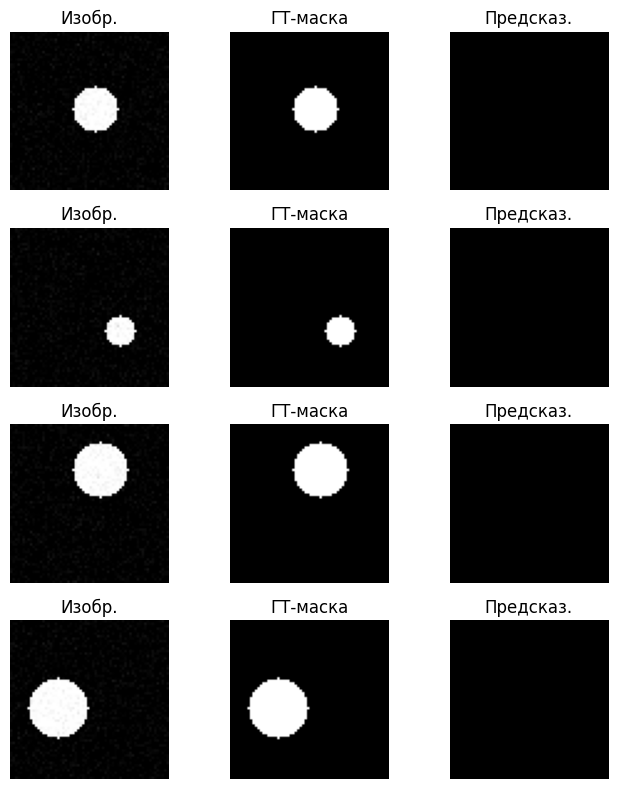

Epoch 20: train_loss=0.7063, val_loss=0.6788


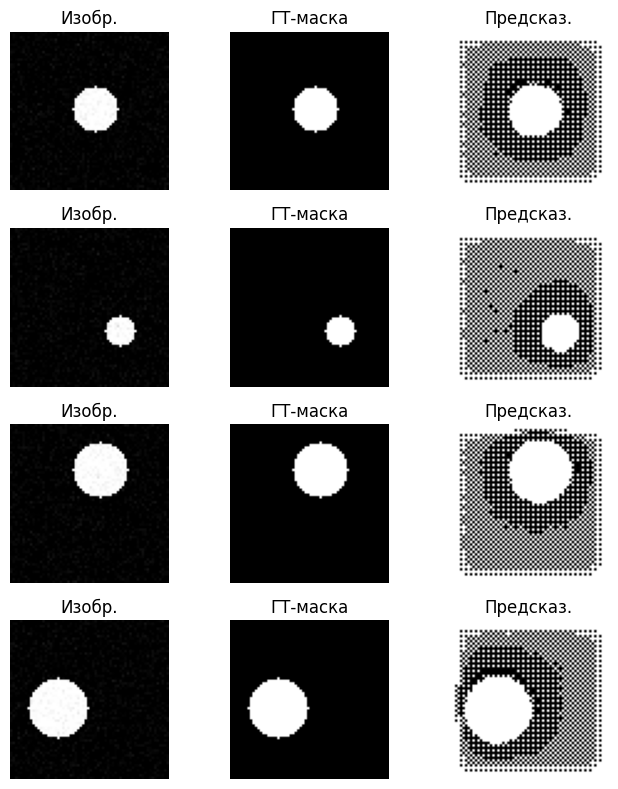

Epoch 30: train_loss=0.0739, val_loss=0.0606


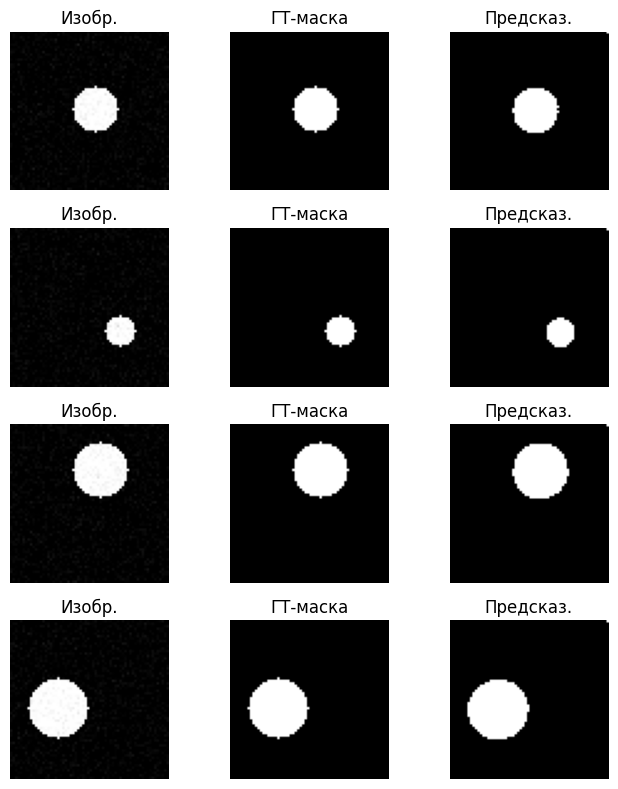

Epoch 40: train_loss=0.0157, val_loss=0.0119


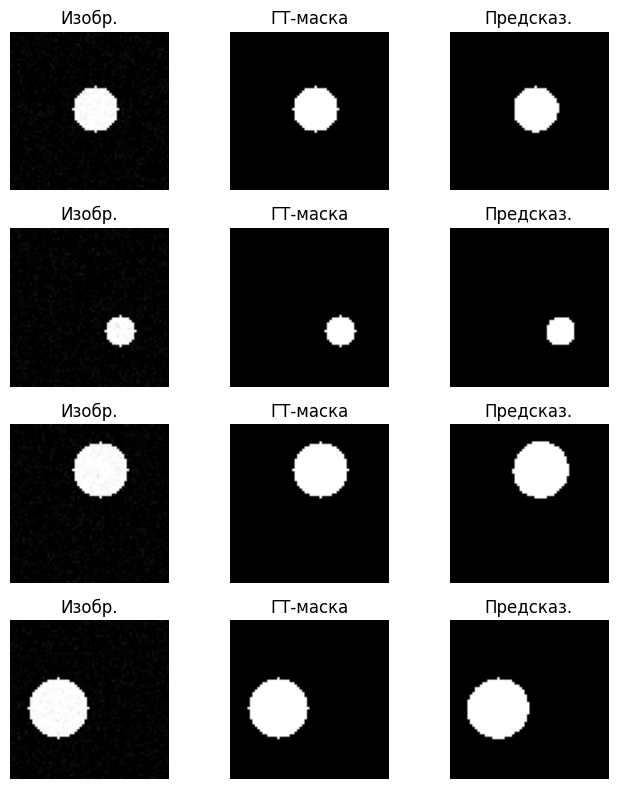

Epoch 50: train_loss=0.0120, val_loss=0.0129


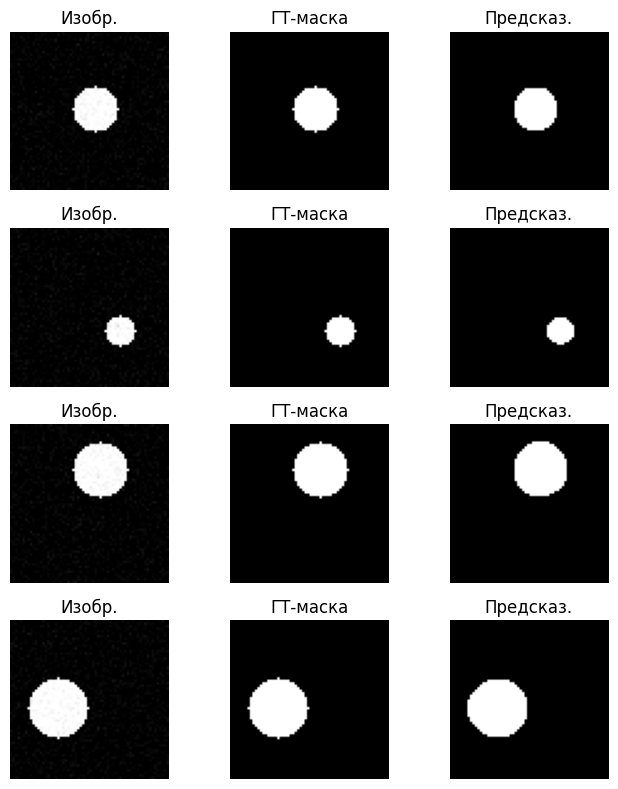

In [14]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def make_synthetic_batch(n=64, sz=64):
    imgs = np.zeros((n, sz, sz), dtype=np.float32)
    masks = np.zeros((n, sz, sz), dtype=np.float32)
    rng = np.random.default_rng(42)
    for i in range(n):
        img = np.zeros((sz,sz), dtype=np.float32)
        mask = np.zeros((sz,sz), dtype=np.float32)
        # случайно круг или прямоугольник
        if rng.random() < 0.5:
            # круг
            cx, cy = rng.integers(16, sz-16, size=2)
            r = rng.integers(6, 14)
            y,x = np.ogrid[:sz,:sz]
            circle = (x-cx)**2 + (y-cy)**2 <= r*r
            img[circle] = 1.0
            mask[circle] = 1.0
        else:
            # прямоугольник
            x1,y1 = rng.integers(5, sz-25, size=2)
            w,h = rng.integers(8, 20, size=2)
            x2,y2 = min(sz-1, x1+w), min(sz-1, y1+h)
            img[y1:y2, x1:x2] = 1.0
            mask[y1:y2, x1:x2] = 1.0
        # лёгкий шум
        img += rng.normal(0, 0.03, size=img.shape).astype(np.float32)
        img = np.clip(img, 0, 1)
        imgs[i] = img
        masks[i] = mask
    return imgs, masks

X_img, Y_mask = make_synthetic_batch(256, 64)
Xtr, Ytr = torch.tensor(X_img[:200]).unsqueeze(1), torch.tensor(Y_mask[:200]).unsqueeze(1)
Xva, Yva = torch.tensor(X_img[200:256]).unsqueeze(1), torch.tensor(Y_mask[200:256]).unsqueeze(1)

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.seq(x)

class MiniUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = DoubleConv(1, 16)
        self.p1 = nn.MaxPool2d(2)
        self.d2 = DoubleConv(16, 32)
        self.p2 = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(32, 64)
        self.up2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.u2 = DoubleConv(64, 32)
        self.up1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.u1 = DoubleConv(32, 16)
        self.out = nn.Conv2d(16, 1, 1)
    def forward(self, x):
        x1 = self.d1(x)
        x2 = self.d2(self.p1(x1))
        xb = self.bottleneck(self.p2(x2))
        x = self.up2(xb)
        x = self.u2(torch.cat([x, x2], dim=1))
        x = self.up1(x)
        x = self.u1(torch.cat([x, x1], dim=1))
        return self.out(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = MiniUNet().to(device)
opt = optim.Adam(net.parameters(), lr=1e-3)
bce = nn.BCEWithLogitsLoss()

Xtr, Ytr = Xtr.to(device), Ytr.to(device)
Xva, Yva = Xva.to(device), Yva.to(device)

for epoch in range(50):
    net.train()
    opt.zero_grad()
    pred = net(Xtr)
    loss = bce(pred, Ytr)
    loss.backward(); opt.step()
    with torch.no_grad():
        net.eval()
        val = net(Xva)
        val_loss = bce(val, Yva).item()
    if (epoch+1)%10==0:
        print(f"Epoch {epoch+1}: train_loss={loss.item():.4f}, val_loss={val_loss:.4f}")

        # Визуализация
        with torch.no_grad():
            net.eval()
            sample = Xva[:4]
            pm = torch.sigmoid(net(sample)).cpu().numpy()

        fig, axes = plt.subplots(4,3, figsize=(7,8))
        for i in range(4):
            axes[i,0].imshow(sample[i,0].cpu(), cmap="gray"); axes[i,0].set_title("Изобр.")
            axes[i,1].imshow(Yva[i,0].cpu(), cmap="gray"); axes[i,1].set_title("ГТ-маска")
            axes[i,2].imshow(pm[i,0] > 0.5, cmap="gray"); axes[i,2].set_title("Предсказ.")
            for j in range(3): axes[i,j].axis("off")
        plt.tight_layout(); plt.show()


## 8. Предобученная сегментационная сеть (PyTorch): DeepLabv3-ResNet50


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /mnt/d/caches/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:07<00:00, 22.8MB/s] 


Модель и веса загружены успешно.


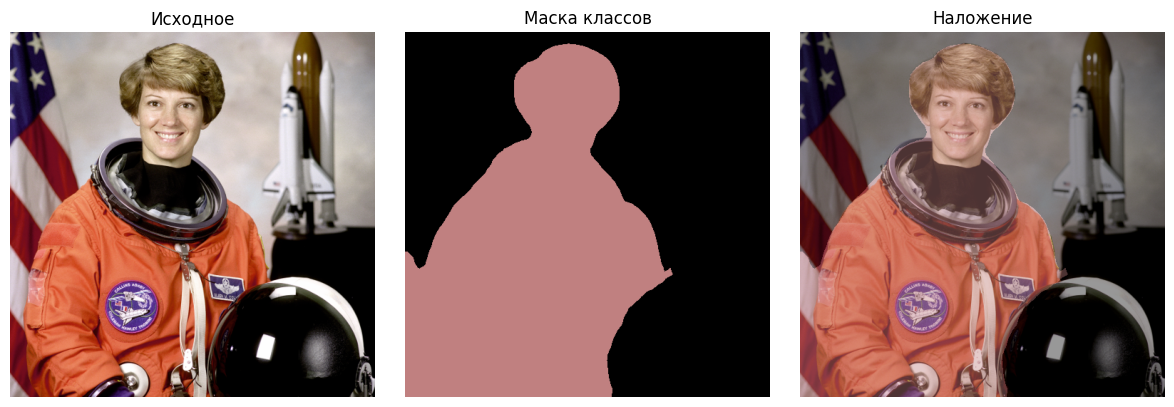

In [15]:
import torch, numpy as np, matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from skimage.data import astronaut
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img_np = astronaut()
img_pil = Image.fromarray(img_np)

tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
inp = tfm(img_pil).unsqueeze(0).to(device)

try:
    model = deeplabv3_resnet50(weights="DEFAULT").to(device).eval()
    with torch.no_grad():
        out = model(inp)["out"]
    pred = out.argmax(1).squeeze().cpu().numpy()
    print("Модель и веса загружены успешно.")
except Exception as e:
    print("Не удалось загрузить предобученные веса автоматически.")
    print("Сообщение:", e)
    print("Подсказка: установите torchvision>=0.13 и запустите с интернетом либо заранее скачайте веса.")
    pred = np.zeros((img_np.shape[0], img_np.shape[1]), dtype=np.int32)

palette = np.array([
    [0,0,0],[128,0,0],[0,128,0],[128,128,0],[0,0,128],
    [128,0,128],[0,128,128],[128,128,128],[64,0,0],[192,0,0],
    [64,128,0],[192,128,0],[64,0,128],[192,0,128],[64,128,128],[192,128,128]
], dtype=np.uint8)

mask_rgb = palette[pred % len(palette)]
overlay = (0.6*img_np + 0.4*mask_rgb).astype(np.uint8)

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(img_np); ax[0].set_title("Исходное"); ax[0].axis("off")
ax[1].imshow(mask_rgb); ax[1].set_title("Маска классов"); ax[1].axis("off")
ax[2].imshow(overlay); ax[2].set_title("Наложение"); ax[2].axis("off")
plt.tight_layout(); plt.show()
